# Exploring the NHANES diabetes data

[DSLC stages]: EDA


You can conduct an EDA of the NHANES diabetes dataset in this document.

In [24]:
import pandas as pd
import numpy as np

# Load the datasets from CSV files
train_data = pd.read_csv('train_data.csv')
val_data = pd.read_csv('val_data.csv')
test_data = pd.read_csv('test_data.csv')
dictionary = pd.read_csv('dictionary.csv', index_col=0)

train_time_data = pd.read_csv('train_time_data.csv')
val_time_data = pd.read_csv('val_time_data.csv')
test_time_data = pd.read_csv('test_time_data.csv')
dict_time_series = pd.read_csv('dict_time_series.csv', index_col=0)

data_States = pd.read_csv('data_States.csv')
data_register = pd.read_csv('data_register.csv')
data_income = pd.read_csv('data_income.csv')
data_noVote = pd.read_csv('data_noVote.csv')

In [25]:
from scipy.stats import ttest_rel, t
import pandas as pd
import numpy as np

# Assuming train_data contains columns starting with "PRE_" and "POST_", and "weights"
pre_columns = [col for col in train_data.columns if col.startswith("PRE_")]
post_columns = [col for col in train_data.columns if col.startswith("POST_")]

# Match PRE and POST columns (ignoring "PRE_" and "POST_" prefixes)
pre_post_pairs = {
    pre: pre.replace("PRE_", "POST_") for pre in pre_columns if pre.replace("PRE_", "POST_") in post_columns
}

# Prepare a DataFrame to store test results
results = []

# Compare each PRE-POST pair
for pre_col, post_col in pre_post_pairs.items():
    pre_data = train_data[pre_col]
    post_data = train_data[post_col]
    weights = train_data['weights'].loc[pre_data.index]  # Align weights with data
    
    # Ensure equal length for paired testing
    paired_data = pd.DataFrame({
        "pre": pre_data,
        "post": post_data,
        "weights": weights
    }).dropna()
    
    pre_values = paired_data["pre"].astype(float)
    post_values = paired_data["post"].astype(float)
    weights = paired_data["weights"].astype(float)
    n = len(pre_values)  # Sample size
    
    # **Unweighted Tests**
    try:
        unweighted_t_stat, unweighted_p_value = ttest_rel(pre_values, post_values)
        unweighted_test_type = "t-test"
        
        # Calculate confidence intervals for unweighted test
        unweighted_mean_diff = post_values.mean() - pre_values.mean()
        unweighted_std_dev_diff = (post_values - pre_values).std()
        unweighted_se_diff = unweighted_std_dev_diff / np.sqrt(n)
        unweighted_t_critical = t.ppf(1 - 0.05 / 2, df=n - 1)
        unweighted_ci_lower = pre_values.mean() - unweighted_t_critical * unweighted_se_diff
        unweighted_ci_upper = pre_values.mean() + unweighted_t_critical * unweighted_se_diff
        
    except ValueError:
        # If t-test fails, default to Wilcoxon (non-parametric)
        unweighted_t_stat, unweighted_p_value = wilcoxon(pre_values, post_values)
        unweighted_test_type = "Wilcoxon"
        unweighted_ci_lower, unweighted_ci_upper = None, None  # CI not computed for Wilcoxon

    # **Weighted Tests**
    diff = post_values - pre_values
    weighted_mean_diff = np.sum(weights * diff) / np.sum(weights)
    weighted_var_diff = np.sum(weights * (diff - weighted_mean_diff) ** 2) / np.sum(weights)
    weighted_se_diff = np.sqrt(weighted_var_diff / n)  # Weighted standard error
    weighted_t_stat = weighted_mean_diff / weighted_se_diff
    df = n - 1  # Degrees of freedom
    pre_weighted_mean = (pre_values * weights).sum() / weights.sum(),
    post_weighted_mean = (post_values * weights).sum() / weights.sum()

    # Calculate p-value (two-tailed test)
    weighted_p_value = 2 * (1 - t.cdf(np.abs(weighted_t_stat), df))

    # Calculate confidence intervals for weighted test
    weighted_t_critical = t.ppf(1 - 0.05 / 2, df)
    weighted_ci_lower =  pre_weighted_mean - weighted_t_critical * weighted_se_diff
    weighted_ci_upper =  pre_weighted_mean + weighted_t_critical * weighted_se_diff

    # Store results
    results.append({
        "Variable": pre_col.replace("PRE_", ""),
        "PRE_Mean_Unweighted": pre_values.mean(),
        "POST_Mean_Unweighted": post_values.mean(),
        "PRE_Mean_Weighted":  pre_weighted_mean,
        "POST_Mean_Weighted":  post_weighted_mean,
        "Unweighted_Test_Type": unweighted_test_type,
        "Unweighted_Mean_Difference": unweighted_mean_diff,
        "Unweighted_CI_Lower": unweighted_ci_lower,
        "Unweighted_CI_Upper": unweighted_ci_upper,
        "Unweighted_T_Statistic": unweighted_t_stat,
        "Unweighted_P_Value": unweighted_p_value,
        "Weighted_Mean_Difference": weighted_mean_diff,
        "Weighted_CI_Lower": weighted_ci_lower,
        "Weighted_CI_Upper": weighted_ci_upper,
        "Weighted_T_Statistic": weighted_t_stat,
        "Weighted_P_Value": weighted_p_value
    })

# Convert results to a DataFrame
comparison_results = pd.DataFrame(results)

# Display significant changes (p-value < 0.05 for weighted and unweighted)
significant_unweighted = comparison_results[comparison_results["Unweighted_P_Value"] < 0.05]
significant_weighted = comparison_results[comparison_results["Weighted_P_Value"] < 0.05]

print("All variables considered\n", comparison_results["Variable"])
print()

print("Significant Changes from Pre to Post (Unweighted):")
print(significant_unweighted[['Variable','PRE_Mean_Unweighted','POST_Mean_Unweighted','Unweighted_P_Value']])

print("\nSignificant Changes from Pre to Post (Weighted):")
print(significant_weighted[['Variable','PRE_Mean_Weighted','POST_Mean_Weighted','Weighted_P_Value']])


All variables considered
 0                    ThermoBiden
1                    ThermoTrump
2                   ThermoHarris
3                    ThermoPence
4                   VoteAccuracy
5     VotePresident_Donald Trump
6     VotePresident_Jo Jorgensen
7    VotePresident_Howie Hawkins
Name: Variable, dtype: object

Significant Changes from Pre to Post (Unweighted):
                      Variable  PRE_Mean_Unweighted  POST_Mean_Unweighted  \
0                  ThermoBiden            49.048482             51.159248   
1                  ThermoTrump            40.678054             39.785197   
2                 ThermoHarris            47.819186             49.453416   
3                  ThermoPence            44.384231             47.273292   
4                 VoteAccuracy             3.074534              2.289683   
5   VotePresident_Donald Trump             0.449275              0.493444   
6   VotePresident_Jo Jorgensen             0.030538              0.010870   
7  VotePresi

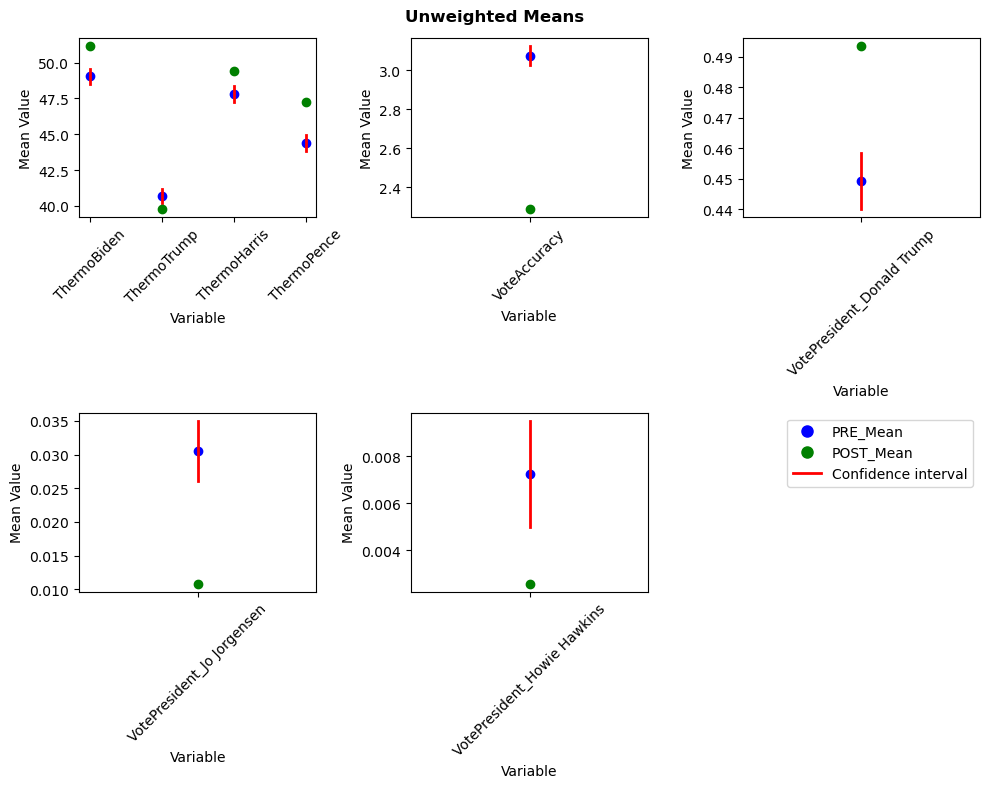

In [26]:
import matplotlib.pyplot as plt

unweighted_data = weighted_data = comparison_results

# Create a figure and axes for subplots (2x2 grid)
fig, axes = plt.subplots(2, 3, figsize=(10, 8))  # 2 rows, 2 columns

# Flatten the axes array to iterate over them easily
axes = axes.flatten()

# Loop for first 4 variables (subplot 1)
for i, var in enumerate(unweighted_data["Variable"][:4]):
    ax = axes[0]  # Use the first subplot (top-left)
    
    # Plot the points for PRE_Mean
    ax.plot(var, unweighted_data["PRE_Mean_Unweighted"][i], 'o', color='blue', label='PRE_Mean' if i == 0 else "")
    
    # Add confidence interval lines
    ax.plot([var, var], [unweighted_data["Unweighted_CI_Lower"][i], unweighted_data["Unweighted_CI_Upper"][i]], 
            color='red', label='Confidence interval' if i == 0 else "", lw=2)
    
    # Plot the points for POST_Mean
    ax.plot(var, unweighted_data["POST_Mean_Unweighted"][i], 'o', color='green', label='POST_Mean' if i == 0 else "")

# Subplot 2 (for variable index 4)
ax = axes[1]  # Use the second subplot (top-right)
var = unweighted_data["Variable"][4]

# Plot the points for PRE_Mean
ax.plot(var, unweighted_data["PRE_Mean_Unweighted"][4], 'o', color='blue', label='PRE_Mean')

# Add confidence interval lines
ax.plot([var, var], [unweighted_data["Unweighted_CI_Lower"][4], unweighted_data["Unweighted_CI_Upper"][4]], 
        color='red', label='Confidence interval', lw=2)

# Plot the points for POST_Mean
ax.plot(var, unweighted_data["POST_Mean_Unweighted"][4], 'o', color='green', label='POST_Mean')


# Loop for remaining variables (subplot 3)
for i, var in enumerate(unweighted_data["Variable"][5:6]):
    ax = axes[2]  # Use the third subplot (bottom-left)
    
    # Plot the points for PRE_Mean
    ax.plot(var, unweighted_data["PRE_Mean_Unweighted"][i+5], 'o', color='blue', label='PRE_Mean' if i == 0 else "")
    
    # Add confidence interval lines
    ax.plot([var, var], [unweighted_data["Unweighted_CI_Lower"][i+5], unweighted_data["Unweighted_CI_Upper"][i+5]], 
            color='red', label='Confidence interval' if i == 0 else "", lw=2)
    
    # Plot the points for POST_Mean
    ax.plot(var, unweighted_data["POST_Mean_Unweighted"][i+5], 'o', color='green', label='POST_Mean' if i == 0 else "")
    
# Loop for remaining variables (subplot 3)
for i, var in enumerate(unweighted_data["Variable"][6:7]):
    ax = axes[3]  # Use the third subplot (bottom-left)
    
    # Plot the points for PRE_Mean
    ax.plot(var, unweighted_data["PRE_Mean_Unweighted"][i+6], 'o', color='blue', label='PRE_Mean' if i == 0 else "")
    
    # Add confidence interval lines
    ax.plot([var, var], [unweighted_data["Unweighted_CI_Lower"][i+6], unweighted_data["Unweighted_CI_Upper"][i+6]], 
            color='red', label='Confidence interval' if i == 0 else "", lw=2)
    
    # Plot the points for POST_Mean
    ax.plot(var, unweighted_data["POST_Mean_Unweighted"][i+6], 'o', color='green', label='POST_Mean' if i == 0 else "")

# Loop for remaining variables (subplot 3)
for i, var in enumerate(unweighted_data["Variable"][7:]):
    ax = axes[4]  # Use the third subplot (bottom-left)
    
    # Plot the points for PRE_Mean
    ax.plot(var, unweighted_data["PRE_Mean_Unweighted"][i+7], 'o', color='blue', label='PRE_Mean' if i == 0 else "")
    
    # Add confidence interval lines
    ax.plot([var, var], [unweighted_data["Unweighted_CI_Lower"][i+7], unweighted_data["Unweighted_CI_Upper"][i+7]], 
            color='red', label='Confidence interval' if i == 0 else "", lw=2)
    
    # Plot the points for POST_Mean
    ax.plot(var, unweighted_data["POST_Mean_Unweighted"][i+7], 'o', color='green', label='POST_Mean' if i == 0 else "")

# Remove the 4th subplot (bottom-right) by turning off its axis
axes[5].axis('off')


import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Create custom legend handles
blue_dot = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=8, label='PRE_Mean')
green_dot = mlines.Line2D([], [], color='green', marker='o', linestyle='None', markersize=8, label='POST_Mean')
red_line = mlines.Line2D([], [], color='red', linestyle='-', linewidth=2, label='Confidence interval')

# Add the custom legend
plt.legend(handles=[blue_dot, green_dot, red_line], loc='best', fontsize=10)

# Adjust the x-axis labels for all subplots (tilt them)
for ax in axes:
    ax.set_xlabel('Variable')
    ax.set_ylabel('Mean Value')
    ax.tick_params(axis='x', rotation=45)  # Tilt the x-axis labels

# Add the legend in the bottom-right of the figure
#fig.legend(loc='lower right', bbox_to_anchor=(1, 0.1), fontsize=12)

# Adjust layout to avoid overlap
fig.suptitle('Unweighted Means', fontweight='bold')
plt.tight_layout()
plt.show()


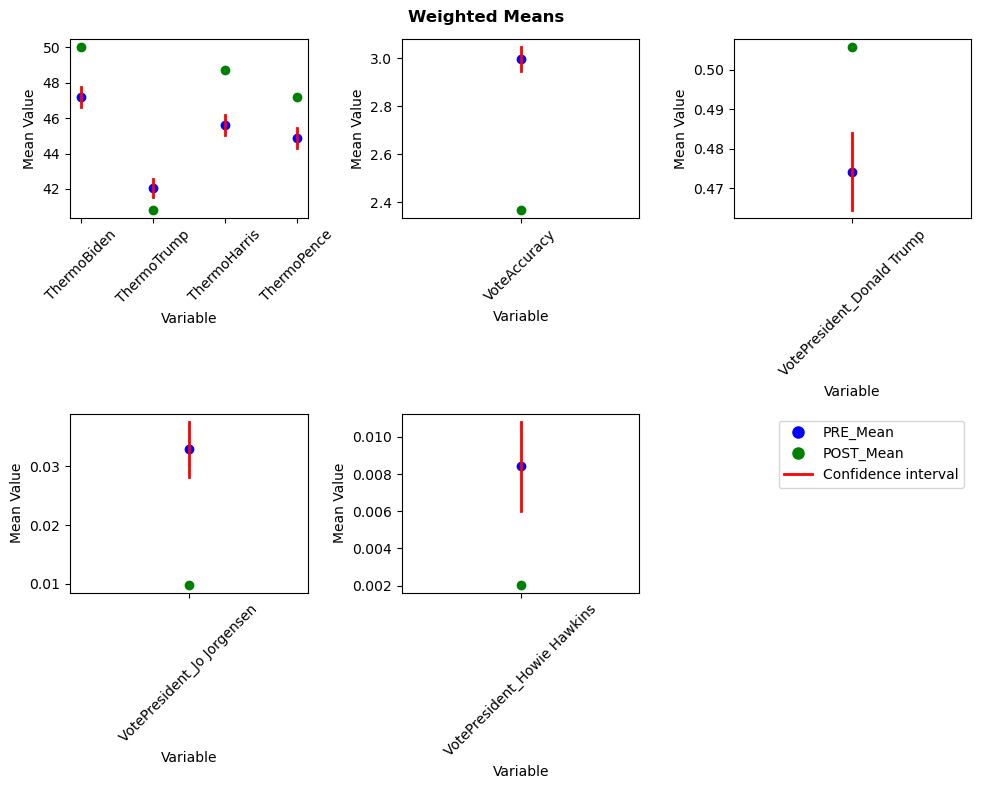

In [27]:
import matplotlib.pyplot as plt

unweighted_data = weighted_data = comparison_results

# Create a figure and axes for subplots (2x2 grid)
fig, axes = plt.subplots(2, 3, figsize=(10, 8))  # 2 rows, 2 columns

# Flatten the axes array to iterate over them easily
axes = axes.flatten()

# Loop for first 4 variables (subplot 1)
for i, var in enumerate(weighted_data["Variable"][:4]):
    ax = axes[0]  # Use the first subplot (top-left)
    
    # Plot the points for PRE_Mean
    ax.plot(var, weighted_data["PRE_Mean_Weighted"][i], 'o', color='blue', label='PRE_Mean' if i == 0 else "")
    
    # Add confidence interval lines
    ax.plot([var, var], [weighted_data["Weighted_CI_Lower"][i], weighted_data["Weighted_CI_Upper"][i]], 
            color='red', label='Confidence interval' if i == 0 else "", lw=2)
    
    # Plot the points for POST_Mean
    ax.plot(var, weighted_data["POST_Mean_Weighted"][i], 'o', color='green', label='POST_Mean' if i == 0 else "")

# Subplot 2 (for variable index 4)
ax = axes[1]  # Use the second subplot (top-right)
var = weighted_data["Variable"][4]

# Plot the points for PRE_Mean
ax.plot(var, weighted_data["PRE_Mean_Weighted"][4], 'o', color='blue', label='PRE_Mean')

# Add confidence interval lines
ax.plot([var, var], [weighted_data["Weighted_CI_Lower"][4], weighted_data["Weighted_CI_Upper"][4]], 
        color='red', label='Confidence interval', lw=2)

# Plot the points for POST_Mean
ax.plot(var, weighted_data["POST_Mean_Weighted"][4], 'o', color='green', label='POST_Mean')

# Loop for remaining variables (subplot 3)
for i, var in enumerate(weighted_data["Variable"][5:6]):
    ax = axes[2]  # Use the third subplot (bottom-left)
    
    # Plot the points for PRE_Mean
    ax.plot(var, weighted_data["PRE_Mean_Weighted"][i+5], 'o', color='blue', label='PRE_Mean' if i == 0 else "")
    
    # Add confidence interval lines
    ax.plot([var, var], [weighted_data["Weighted_CI_Lower"][i+5], weighted_data["Weighted_CI_Upper"][i+5]], 
            color='red', label='Confidence interval' if i == 0 else "", lw=2)
    
    # Plot the points for POST_Mean
    ax.plot(var, weighted_data["POST_Mean_Weighted"][i+5], 'o', color='green', label='POST_Mean' if i == 0 else "")

# Loop for remaining variables (subplot 3)
for i, var in enumerate(weighted_data["Variable"][6:7]):
    ax = axes[3]  # Use the third subplot (bottom-left)
    
    # Plot the points for PRE_Mean
    ax.plot(var, weighted_data["PRE_Mean_Weighted"][i+6], 'o', color='blue', label='PRE_Mean' if i == 0 else "")
    
    # Add confidence interval lines
    ax.plot([var, var], [weighted_data["Weighted_CI_Lower"][i+6], weighted_data["Weighted_CI_Upper"][i+6]], 
            color='red', label='Confidence interval' if i == 0 else "", lw=2)
    
    # Plot the points for POST_Mean
    ax.plot(var, weighted_data["POST_Mean_Weighted"][i+6], 'o', color='green', label='POST_Mean' if i == 0 else "")

# Loop for remaining variables (subplot 3)
for i, var in enumerate(weighted_data["Variable"][7:]):
    ax = axes[4]  # Use the third subplot (bottom-left)
    
    # Plot the points for PRE_Mean
    ax.plot(var, weighted_data["PRE_Mean_Weighted"][i+7], 'o', color='blue', label='PRE_Mean' if i == 0 else "")
    
    # Add confidence interval lines
    ax.plot([var, var], [weighted_data["Weighted_CI_Lower"][i+7], weighted_data["Weighted_CI_Upper"][i+7]], 
            color='red', label='Confidence interval' if i == 0 else "", lw=2)
    
    # Plot the points for POST_Mean
    ax.plot(var, weighted_data["POST_Mean_Weighted"][i+7], 'o', color='green', label='POST_Mean' if i == 0 else "")

# Remove the 4th subplot (bottom-right) by turning off its axis
axes[5].axis('off')


import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Create custom legend handles
blue_dot = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=8, label='PRE_Mean')
green_dot = mlines.Line2D([], [], color='green', marker='o', linestyle='None', markersize=8, label='POST_Mean')
red_line = mlines.Line2D([], [], color='red', linestyle='-', linewidth=2, label='Confidence interval')

# Add the custom legend
plt.legend(handles=[blue_dot, green_dot, red_line], loc='best', fontsize=10)


# Adjust the x-axis labels for all subplots (tilt them)
for ax in axes:
    ax.set_xlabel('Variable')
    ax.set_ylabel('Mean Value')
    ax.tick_params(axis='x', rotation=45)  # Tilt the x-axis labels

# Add the legend in the bottom-right of the figure
#fig.legend(loc='lower right', bbox_to_anchor=(1, 0.1), fontsize=12)

# Adjust layout to avoid overlap
fig.suptitle('Weighted Means', fontweight='bold')
plt.tight_layout()
plt.show()

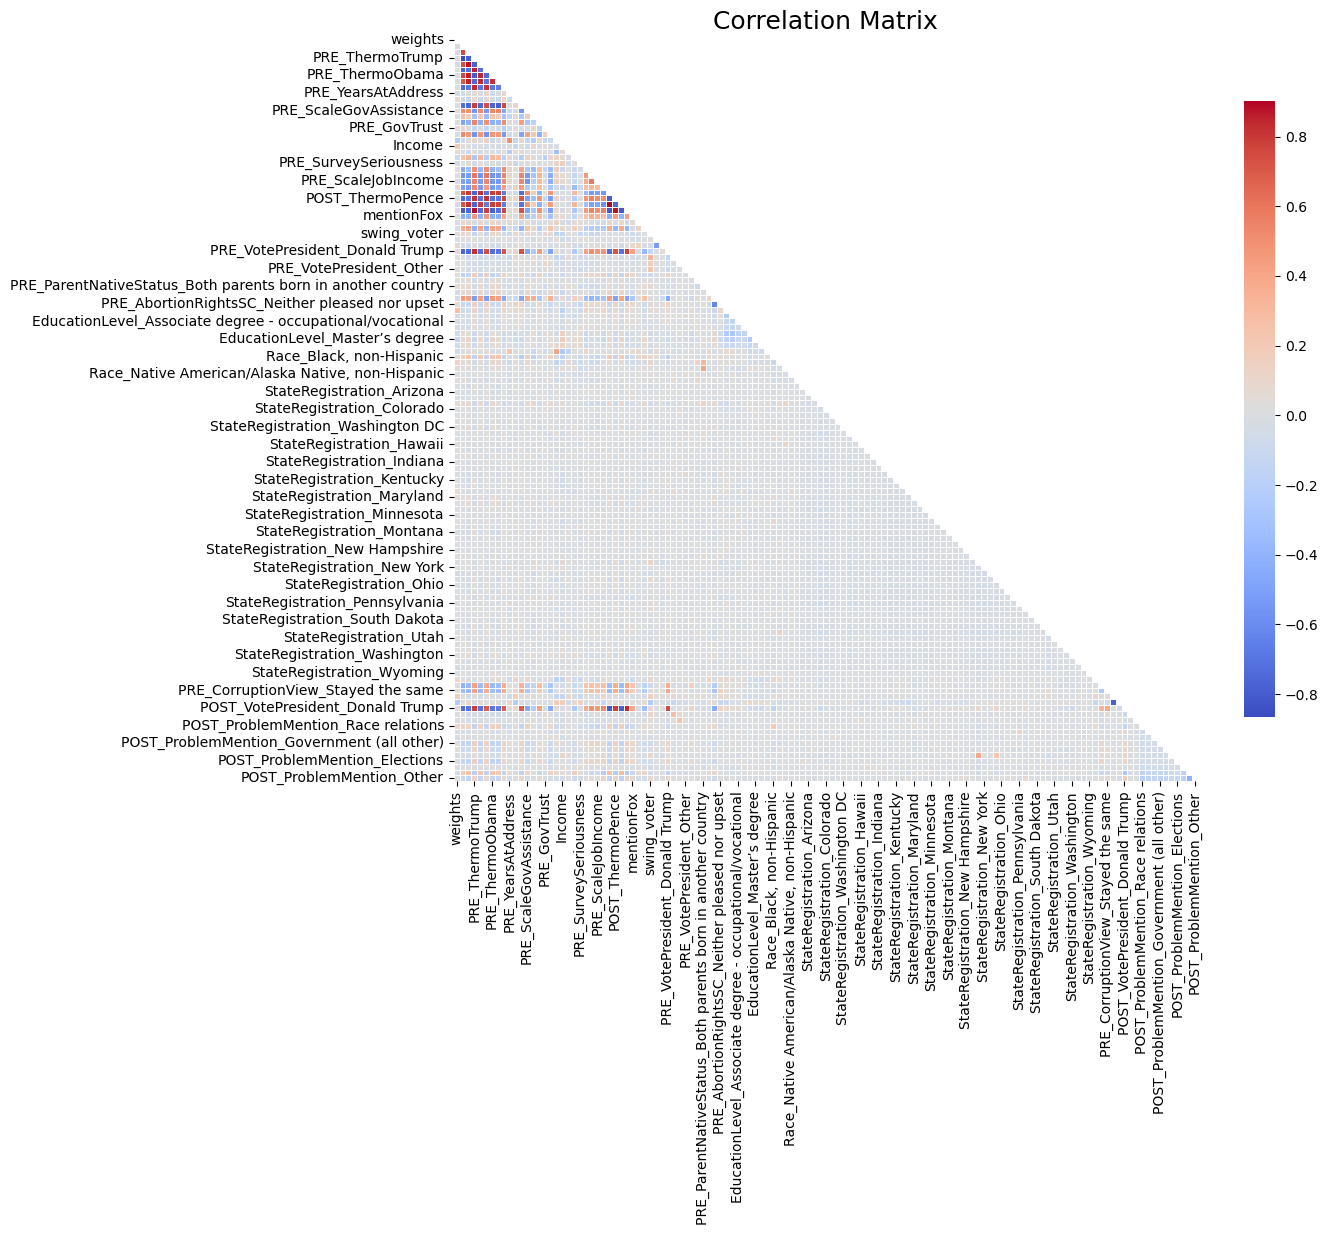

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix =  train_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create a heatmap with customizations
sns.heatmap(correlation_matrix, 
            annot=False,                # Annotate cells with the numeric values
            fmt=".2f",                # Format the annotation text
            cmap='coolwarm',          # Color map
            mask = mask,
            square=True,              # Make cells square-shaped
            cbar_kws={"shrink": .8},  # Color bar size
            linewidths=.5,           # Line width between cells
            linecolor='white',        # Line color between cells
            annot_kws={"size": 6})   # Adjust the font size for annotations

# Add title
plt.title('Correlation Matrix', fontsize=18)
plt.savefig('Correlation Matrix Heat Map')
plt.show()

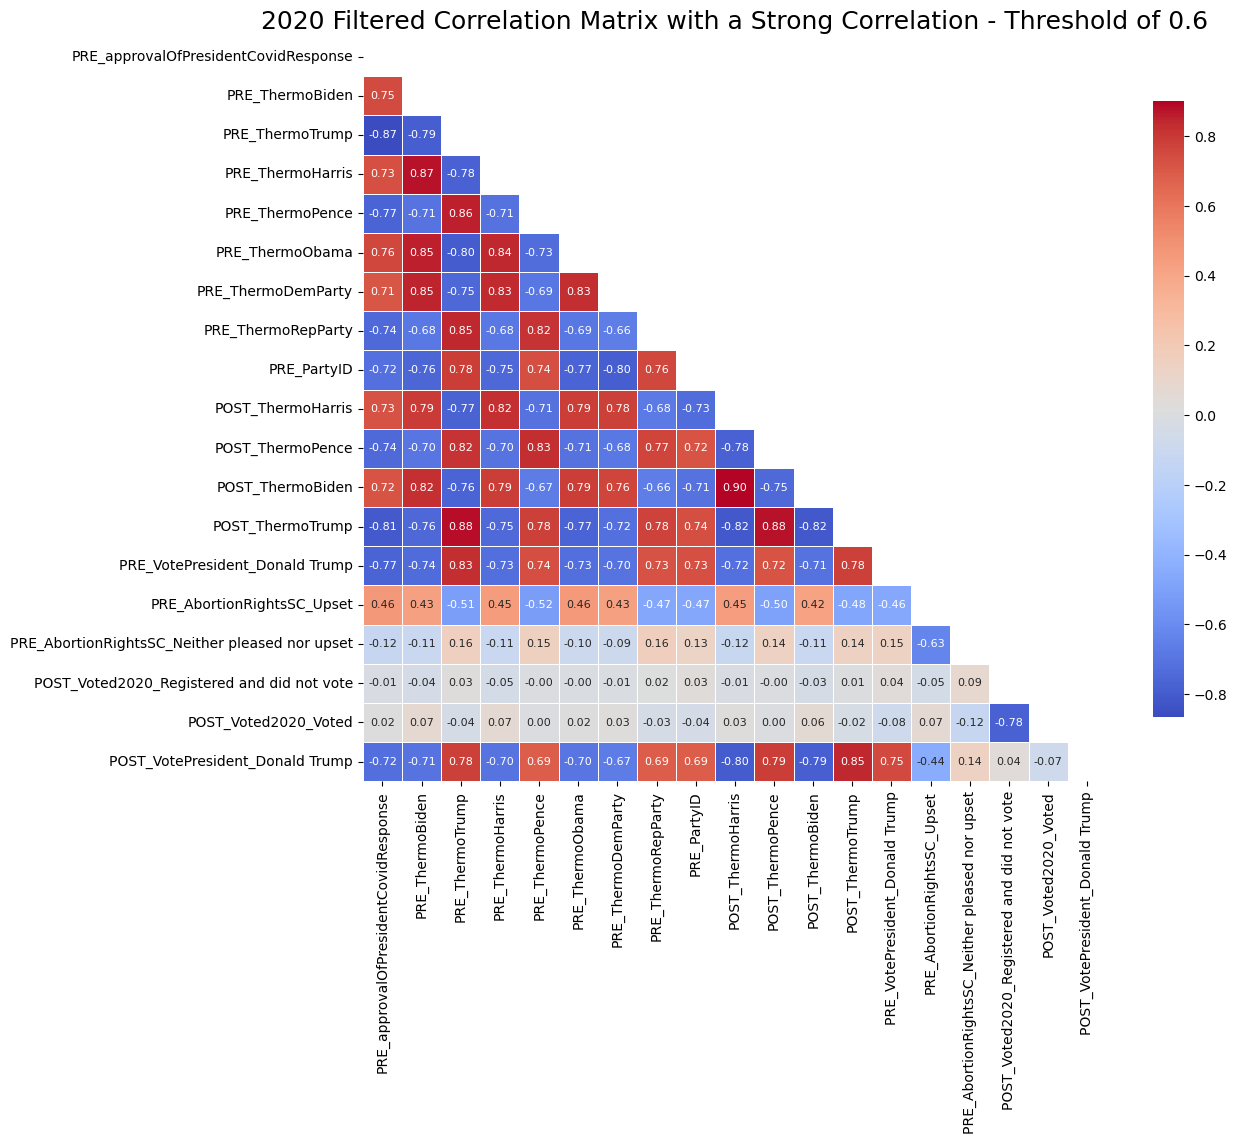

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define a threshold for strong correlations
threshold = 0.6

# Filter the correlation matrix
filtered_correlation_matrix = correlation_matrix.copy()
filtered_correlation_matrix[
    (filtered_correlation_matrix < threshold) & (filtered_correlation_matrix > -threshold)
] = np.nan  # Replace weak correlations with NaN
# Set diagonal elements to NaN
np.fill_diagonal(filtered_correlation_matrix.values, np.nan)

# Drop rows and columns that are completely NaN
filtered_correlation_matrix = filtered_correlation_matrix.dropna(axis=0, how='all')  # Drop rows
filtered_correlation_matrix = filtered_correlation_matrix.dropna(axis=1, how='all')  # Drop columns

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(filtered_correlation_matrix, dtype=bool))

# Identify columns and rows that are not NaN in the filtered correlation matrix
valid_columns = filtered_correlation_matrix.dropna(axis=1, how='all').columns
valid_rows = filtered_correlation_matrix.dropna(axis=0, how='all').index

# Create a new plot matrix that only includes the valid rows and columns
plot_matrix = correlation_matrix.loc[valid_rows, valid_columns]
#print(plot_matrix)

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap with customizations
sns.heatmap(plot_matrix, 
            annot=True,               # Annotate cells with the numeric values
            fmt=".2f",                # Format the annotation text
            cmap='coolwarm',          # Color map
            mask=mask,                # Mask the upper triangle
            square=True,              # Make cells square-shaped
            cbar_kws={"shrink": .8},  # Color bar size
            linewidths=.5,            # Line width between cells
            linecolor='white',        # Line color between cells
            annot_kws={"size": 8})    # Adjust the font size for annotations

# Add title
plt.title('2020 Filtered Correlation Matrix with a Strong Correlation - Threshold of '+str(threshold), fontsize=18)

# Save the plot
plt.savefig('Filtered_Correlation_Matrix.png', dpi=300)

# Show the plot
plt.show()

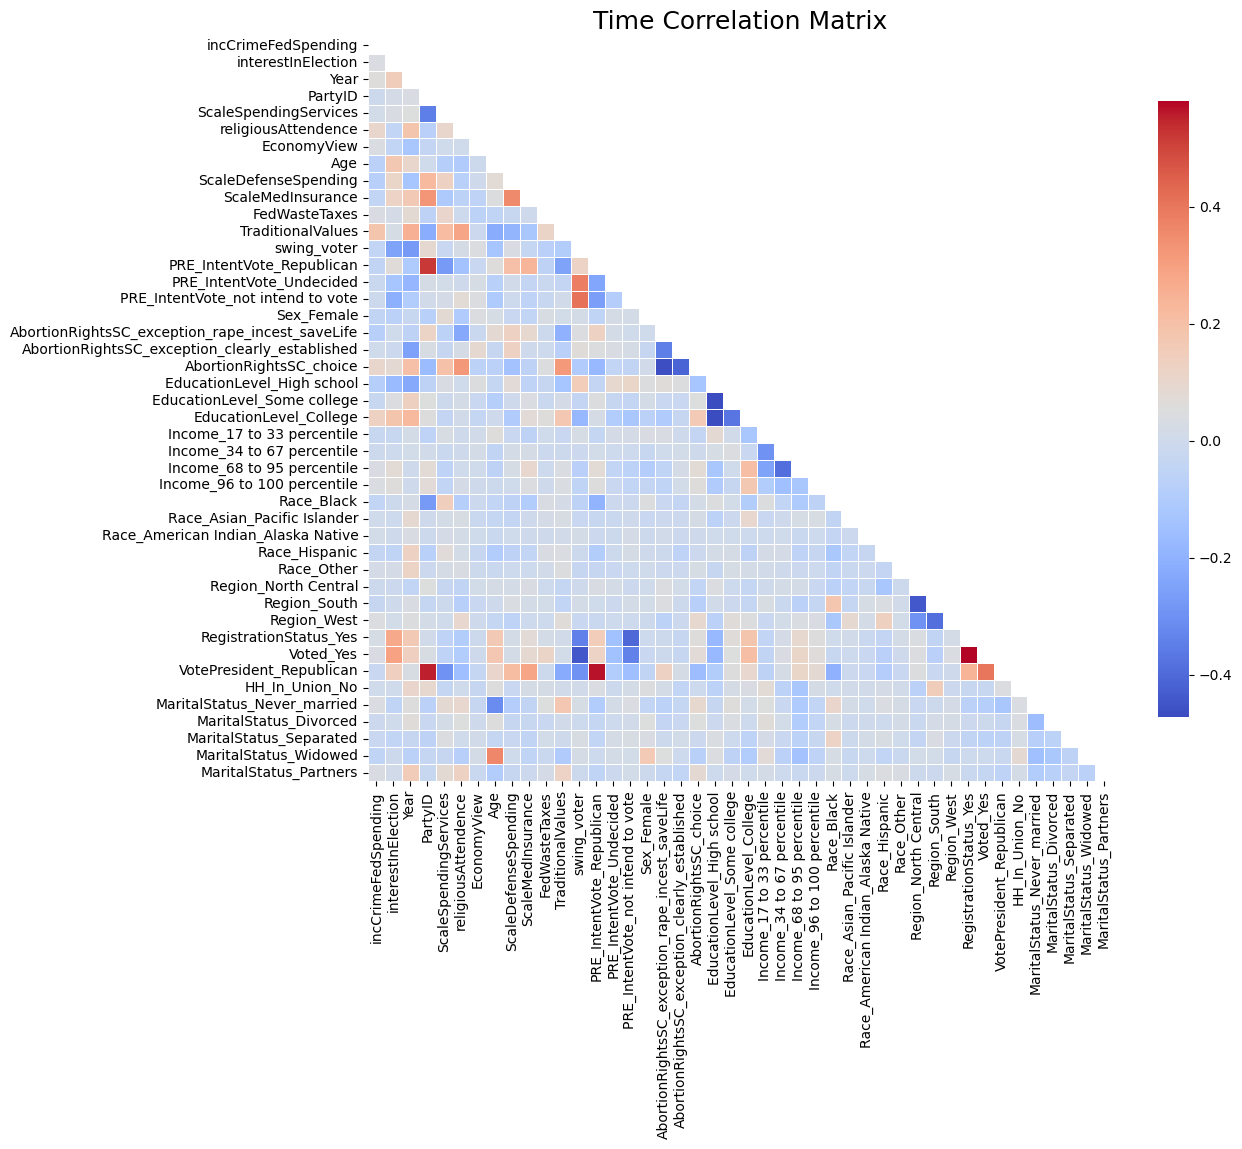

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix_time =  train_time_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix_time, dtype=bool))

# Create a heatmap with customizations
sns.heatmap(correlation_matrix_time, 
            annot=False,                # Annotate cells with the numeric values
            fmt=".2f",                # Format the annotation text
            cmap='coolwarm',          # Color map
            mask = mask,
            square=True,              # Make cells square-shaped
            cbar_kws={"shrink": .8},  # Color bar size
            linewidths=.5,           # Line width between cells
            linecolor='white',        # Line color between cells
            annot_kws={"size": 6})   # Adjust the font size for annotations

# Add title
plt.title('Time Correlation Matrix', fontsize=18)
plt.savefig('Time Correlation Matrix Heat Map')
plt.show()

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define a threshold for strong correlations
threshold = 0.4

# Filter the correlation matrix
filtered_correlation_matrix = correlation_matrix_time.copy()
filtered_correlation_matrix[
    (filtered_correlation_matrix < threshold) & (filtered_correlation_matrix > -threshold)
] = np.nan  # Replace weak correlations with NaN
# Set diagonal elements to NaN
np.fill_diagonal(filtered_correlation_matrix.values, np.nan)

# Drop rows and columns that are completely NaN
filtered_correlation_matrix = filtered_correlation_matrix.dropna(axis=0, how='all')  # Drop rows
filtered_correlation_matrix = filtered_correlation_matrix.dropna(axis=1, how='all')  # Drop columns

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(filtered_correlation_matrix, dtype=bool))

# Identify columns and rows that are not NaN in the filtered correlation matrix
valid_columns = filtered_correlation_matrix.dropna(axis=1, how='all').columns
valid_rows = filtered_correlation_matrix.dropna(axis=0, how='all').index

# Create a new plot matrix that only includes the valid rows and columns
plot_matrix = correlation_matrix.loc[valid_rows, valid_columns]
#print(plot_matrix)

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap with customizations
sns.heatmap(plot_matrix, 
            annot=False,               # Annotate cells with the numeric values
            fmt=".2f",                # Format the annotation text
            cmap='coolwarm',          # Color map
            mask=mask,                # Mask the upper triangle
            square=True,              # Make cells square-shaped
            cbar_kws={"shrink": .8},  # Color bar size
            linewidths=.5,            # Line width between cells
            linecolor='white',        # Line color between cells
            annot_kws={"size": 8})    # Adjust the font size for annotations

# Add title
plt.title('Time Filtered Correlation Matrix with a Strong Correlation - Threshold of '+str(threshold), fontsize=18)

# Save the plot
plt.savefig('Filtered_Correlation_Matrix.png', dpi=300)

# Show the plot
plt.show()

KeyError: "['PartyID', 'PRE_IntentVote_Republican', 'PRE_IntentVote_not intend to vote', 'AbortionRightsSC_exception_rape_incest_saveLife', 'AbortionRightsSC_exception_clearly_established', 'AbortionRightsSC_choice', 'EducationLevel_High school', 'EducationLevel_Some college', 'EducationLevel_College', 'Region_North Central', 'Region_South', 'RegistrationStatus_Yes', 'Voted_Yes', 'VotePresident_Republican'] not in index"

In [ ]:
swing_stats = train_data.groupby('swing_voter').mean()
print(swing_stats)


In [ ]:
import scipy.stats as stats

# Separate the data into two groups
group_0 = train_data[train_data['swing_voter'] == 0]
group_1 = train_data[train_data['swing_voter'] == 1]

# Perform a two-sample t-test for each numeric column
results = {}
for column in train_data.select_dtypes(include='number').columns:
    if column != 'swing_voter':  # Exclude the grouping column
        t_stat, p_value = stats.ttest_ind(group_0[column], group_1[column], nan_policy='omit')
        results[column] = {
            't_statistic': t_stat,
            'p_value': p_value,
            'mean_group_0': group_0[column].mean(),
            'mean_group_1': group_1[column].mean(),
            'significant': p_value <= 0.05  # True if significant at alpha=0.05
        }

# Display the results
import pandas as pd
results_df = pd.DataFrame(results).T
print(results_df)

In [ ]:
swing_stats = train_time_data.groupby('swing_voter').mean()
print(swing_stats)

In [ ]:
import scipy.stats as stats

# Separate the data into two groups
group_0 = train_time_data[train_time_data['swing_voter'] == 0]
group_1 = train_time_data[train_time_data['swing_voter'] == 1]

# Perform a two-sample t-test for each numeric column
results = {}
for column in train_time_data.select_dtypes(include='number').columns:
    if column != 'swing_voter':  # Exclude the grouping column
        t_stat, p_value = stats.ttest_ind(group_0[column], group_1[column], nan_policy='omit')
        results[column] = {
            't_statistic': t_stat,
            'p_value': p_value,
            'mean_group_0': group_0[column].mean(),
            'mean_group_1': group_1[column].mean(),
            'significant': p_value <= 0.05  # True if significant at alpha=0.05
        }

# Display the results
import pandas as pd
results_df = pd.DataFrame(results).T
print(results_df)


In [ ]:
import importlib
# Import the function
from functions import explore_data_helper

# Reload the module to reflect any updates
importlib.reload(explore_data_helper)

# create a list of 100 perturbed versions of ames_train_preprocessed using the perturb_ames function
perturbed_data = [explore_data_helper.perturb_dataframe(train_data) for i in range(100)]

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

# Assuming train_data and perturbed_data are DataFrames
# Assuming explore_data_helper.perturb_dataframe is defined

# Step 1: Calculate the mean for each column in train_data
train_means = train_data.mean()

# Step 2: Calculate the means for each perturbed dataset and store the results
perturbed_means = []

for perturbed_df in perturbed_data:
    perturbed_means.append(perturbed_df.mean())

# Step 3: Perform T-tests to compare means for each column between train_data and perturbed datasets
p_values = {}

# Iterate over each column in the train_data (and perturbed data)
for column in train_data.columns:
    # Get the mean of the train_data for this column
    train_column_values = train_data[column]
    
    # Store the p-values for each perturbation (compare with the train data)
    p_vals_for_column = []
    
    for perturbed_mean in perturbed_means:
        perturbed_column_values = perturbed_mean[column]
        
        # Perform a two-sample t-test between the train data and perturbed data
        t_stat, p_val = ttest_ind(train_column_values, perturbed_column_values)
        p_vals_for_column.append(p_val)
    
    # Store the average p-value for this column across all perturbations
    p_values[column] = np.mean(p_vals_for_column)

# Step 4: Analyze p-values to check for statistically significant differences
# Typically, a p-value below 0.05 suggests a significant difference
significant_columns = {col: p_val for col, p_val in p_values.items() if p_val < 0.05}

# Print columns with significant differences
print("Columns with significant differences (p-value < 0.05):")
for col in significant_columns:
    print(f"{col}: p-value = {significant_columns[col]}")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert list of means for perturbed data to a DataFrame
perturbed_means_df = pd.DataFrame(perturbed_means)

# Step 3: Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Scatter plot of perturbed means (y) vs train means (x)
for i, feature in enumerate(train_means.index):
    ax.scatter(np.repeat(train_means[feature], len(perturbed_means)), perturbed_means_df[feature].values, 
               color='blue', alpha=0.2, label=f'{feature}' if i == 0 else "")
    
# Add a line for perfect agreement (y = x)
plt.plot([min(train_means), max(train_means)],
         [min(train_means), max(train_means)], color='r', linestyle='--')

# Add labels and title
ax.set_xlabel('Train Data Mean')
ax.set_ylabel('Perturbed Data Mean')
ax.set_title('Comparison of Train Data Means vs Perturbed Data Means')

# Optionally, add a legend to describe features
ax.legend(title="Features", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

def compare_means_by_mode(perturbed_data, key_word):
    """
    Compare means of columns where 'interviewMode' is in the column name, 
    grouped by the interview mode categories (True/False).
    
    Parameters:
        perturbed_data (list of pd.DataFrame): List of DataFrames containing the perturbed data to analyze.
    
    Returns:
        p_vals (list of tuples): List of columns and their corresponding p-values from the t-tests.
    """
    p_vals = []
    
    # Iterate over each DataFrame in the list
    for i, df in enumerate(perturbed_data):
        print(f"\nAnalyzing DataFrame {i + 1}...\n")

        # Identify all columns that contain 'interviewMode' in their name
        interview_mode_columns = [col for col in df.columns if key_word in col]
        
        if not interview_mode_columns:
            print("No 'interviewMode' columns found.")
            continue
        
        #print(f"Found interview mode columns: {interview_mode_columns}")
        
        # Loop over all the numerical columns for comparison
        for col in df.select_dtypes(include=np.number).columns:
            #print(f"\nComparing column '{col}' based on interview modes.")

            # Compare the data for each interview mode column (True vs. False)
            for mode in interview_mode_columns:
                mode_true_data = df[df[mode] == True][col]  # Data where mode is True
                mode_false_data = df[df[mode] == False][col]  # Data where mode is False
                
                # Perform t-test between the two interview modes for this numerical column
                t_stat, p_value = ttest_ind(mode_true_data, mode_false_data, nan_policy='omit')
                
                # Append p-value for the column to the list
                p_vals.append((col, p_value))
                
                # Print results
                if p_value < 0.05:
                    print(f"The means for {mode} (True vs False) are significantly different in column '{col}'.")

    return p_vals


In [ ]:
p_vals = compare_means_by_mode(perturbed_data, 'interviewMode')

In [ ]:
from collections import Counter

# Example of tracking how often each feature is significant
significant_features = [col for col, p_value in p_vals if p_value < 0.05]

feature_counts = Counter(significant_features)
sorted_feature_counts = feature_counts.most_common()

print(f"Features with the most significant differences: {sorted_feature_counts}")


In [ ]:
# Separate the feature names and their counts
features, counts = zip(*sorted_feature_counts)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(features, counts, color='skyblue')

# Adding titles and labels
plt.title('Significantly Different Features', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Count of Significant Differences', fontsize=12)

# Rotate feature names if they are too long
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
import importlib
from functions import explore_data_helper
importlib.reload(explore_data_helper)

# create a list of 100 perturbed versions of ames_train_preprocessed using the perturb_ames function
perturbed_time_data = [explore_data_helper.perturb_dataframe(train_time_data) for i in range(100)]

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

# Assuming train_data and perturbed_data are DataFrames
# Assuming explore_data_helper.perturb_dataframe is defined

# Step 1: Calculate the mean for each column in train_data
train_time_means = train_time_data.mean()

# Step 2: Calculate the means for each perturbed dataset and store the results
perturbed_time_means = []

for perturbed_df in perturbed_time_data:
    perturbed_time_means.append(perturbed_df.mean())

# Step 3: Perform T-tests to compare means for each column between train_data and perturbed datasets
p_values = {}

# Iterate over each column in the train_data (and perturbed data)
for column in train_time_data.columns:
    # Get the mean of the train_data for this column
    train_column_values = train_time_data[column]
    
    # Store the p-values for each perturbation (compare with the train data)
    p_vals_for_column = []
    
    for perturbed_mean in perturbed_time_means:
        perturbed_column_values = perturbed_mean[column]
        
        # Perform a two-sample t-test between the train data and perturbed data
        t_stat, p_val = ttest_ind(train_column_values, perturbed_column_values)
        p_vals_for_column.append(p_val)
    
    # Store the average p-value for this column across all perturbations
    p_values[column] = np.mean(p_vals_for_column)

# Step 4: Analyze p-values to check for statistically significant differences
# Typically, a p-value below 0.05 suggests a significant difference
significant_columns = {col: p_val for col, p_val in p_values.items() if p_val < 0.05}

# Print columns with significant differences
print("Columns with significant differences in Time Series (p-value < 0.05):")
for col in significant_columns:
    print(f"{col}: p-value = {significant_columns[col]}")
